In [1]:
import os
import numpy as np
from scipy.io import wavfile
from aubio import onset
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

from read_labels import read_labels

%matplotlib inline

In [2]:
rootdir = '/home/tracek/Data/Birdman/'
filename = os.path.join(rootdir, 'raw/STHELENA-02_20140605_200000_1_16k.wav')
outdir = os.path.join(rootdir, 'raw/samples/')
sheets = read_labels('/home/tracek/Data/StHelena/sthelena_labels.xls')
sheet = sheets['STHELENA-02_20140605_200000_1']

# in seconds [s]
signal_start_s = 0
signal_end_s = 95
min_duration_s = 0.300
max_duration_s = 0.750

win = 256 # samples
hop = win // 2

onset_detector = 'hfc' # other options: complex, phase, specdiff, kl, mkl, specflux, energy
onset_threshold = 0.01
onset_silence_threshold = -70

highpass_cut = 1000 # Hz

In [3]:
sr, signal = wavfile.read(filename)
scaling_factor = 32767 # signal.max()
signal_norm = signal.astype('float32') / scaling_factor

In [4]:
def butter_highpass(highcut, fs, order=12):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

b, a = butter_highpass(highpass_cut, sr, order=12)

In [5]:
onset_detector = onset(onset_detector, win, hop, sr)
onset_detector.set_threshold(onset_threshold)
onset_detector.set_silence(onset_silence_threshold)
onset_detector.set_minioi_s(min_duration_s)

In [6]:
condition = (sheet['Time Start'] > signal_start_s) & (sheet['Time End'] < signal_end_s)
sheet_selected = sheet[condition]
signal_selected = signal_norm[int(signal_start_s * sr): int(signal_end_s * sr)]

signal_filtered = lfilter(b, a, signal_selected).astype('float32')

signal_windowed = np.array_split(signal_filtered, np.arange(hop, len(signal_filtered), hop))

In [7]:
onsets = []

for frame in signal_windowed[:-1]:
    if onset_detector(frame):
        onsets.append(onset_detector.get_last_s() + signal_start_s)
        
print('Found {} onsets in {}s long recording.'.format(len(onsets[1:]), signal_end_s - signal_start_s))

Found 80 onsets in 95s long recording.


In [8]:
def onset_in_call(onset, calls_list, buffer=0):
    for index, call in calls_list.iterrows():
        if call['Time Start'] - buffer >= onset >= call['Time End'] + buffer:
            return call['Species']
    else:
        return None

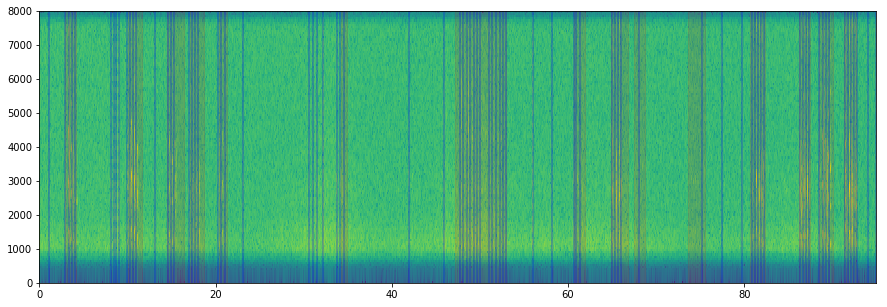

In [9]:
x_spacing = np.linspace(signal_start_s, signal_end_s, len(signal_selected))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for index, row in sheet_selected.iterrows():
    if row['Species'] == 'Storm Petrel':
        ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='red', alpha=0.1)
    else:
        ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='green', alpha=0.2)
for onset in onsets[1:]:
    ax.axvline(x=onset, color='blue', alpha=0.3)
    if onset_in_call(onset, sheet_selected, buffer=0):
        plt.plot(onset, 6000, 'ro')
spec = plt.specgram(signal_filtered, Fs=sr, NFFT=win, noverlap=hop, xextent=(signal_start_s, signal_end_s))

In [11]:
l = []
chunks_s = []

for onset, next_onset in zip(onsets, onsets[1:]):
    interval = next_onset - onset
    cut = next_onset if interval < max_duration_s else onset + max_duration_s
    l.append(cut - onset)
    chunks_s.append((onset, cut))

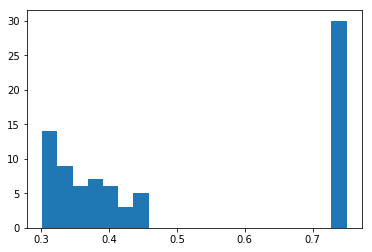

In [12]:
h = plt.hist(l, bins=20)

In [14]:
# sample *= 32767

for start, end in chunks_s[1:]:
    basename = os.path.basename(filename)
    dirname = os.path.dirname(filename)
    call = onset_in_call(start, sheet_selected, buffer=min_duration_s/2)
    if call:
        chunk_name = '{}_{:07.3f}_{:07.3f}_{}.wav'.format(os.path.splitext(basename)[0], start, end, call)
    else:
        chunk_name = '{}_{:07.3f}_{:07.3f}.wav'.format(os.path.splitext(basename)[0], start, end)
    # chunk_name_highpass = '{}_{:07.3f}_{:07.3f}_highpass.wav'.format(os.path.splitext(basename)[0], start, end)
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    chunk_path_out = os.path.join(dirname, chunk_name)
    # chunk_path_out_highpass = os.path.join(dirname, chunk_name_highpass)
    wavfile.write(chunk_path_out, sr, signal[start_sample: end_sample])
    # wavfile.write(chunk_path_out_highpass, sr, sample[start_sample: end_sample])

In [ ]:
chunks = [(int(start*sr), int(end*sr)) for start, end in chunks_s]

In [ ]:
plt.plot(signal)

In [ ]:
plt.plot(sample)

In [ ]:
a = [1,2,3]

In [ ]:
a[0:]

In [16]:
a = {'a': 2, 'b':1}

In [23]:
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [24]:
config['Labels']['path_xls']

'/home/tracek/Data/Birdman/labels/sthelena_labels.xls'